In [1]:
from google.colab.patches import cv2_imshow 
from google.colab import drive 
import cv2, sys, os
import numpy as np
#import matplotlib.pyplot as plt
import math

영상 전처리가 끝난 영상으로 영상에 포함된 물체의 모양을 알 수 있는데

외곽선 추출이나 물체 분할 후 물체 내의 모든 픽셀을 써서 인식할 수 있음 

물체의 고유한 정보를 수치로 표현한 것을 영상의 모양 기술자Shape Descriptor라고 함

- 이상적인 모양 기술자의 조건

  물체의 이동, 회전, 크기변화에도 불변

  특징 벡터 차원을 최소화해야 함

  물체의 전역적인 정보 뿐만 아니라  지역적 정보도 같이 제공해야 함

  유사도 측정방법은 빠르고 정확해야 함


# 전역 모양 기술자 Global Shape Descriptor
  
물체의 전역적인 특성을 나타내는 기술자

1. 둘레 길이 Perimeter

  둘레길이는 경계길이이다. 
  
  적분함수를 통해 도출하며 경계면1, 아니면 0을 출력하는 반식으로 찾는다

  이진화 영상을 에지검출하여 경계를 구한 뒤 방행 연결성으로 픽셀개수를 카운트하여 둘레길이 구함

  OpenCV에서는 둘레길이를 구할 수 있는 arcLength()를 지원함

2. 영역 크기 Area
  물체 안에 포함된 픽셀의 수를 의미
  
  OpenCV의 cv.contourArea()를 사용할 수 있음

3. 원형율 Roundness

  물체가 어느정도 둥근 모양을 갖는지 나타내는 모양기술자

  완전한 원을 1, 완전한 원에서 멀어 질수록 1보다 작은 값을 갖는다

  물체 형상이 원이 아니라 복잡할 수록 1보다 커집. 둘레 길이의 값이 커지기 때문에

  \

  원형율  = (둘레 길이)^2 / 4 * π * (영역 크기) 






원형율 계산 알고리줌 구현

In [2]:
drive.mount('/content/gdrive')
img = '/content/gdrive/My Drive/camera.bmp'
gray_img = cv2.imread(img, 0)

Mounted at /content/gdrive


circle


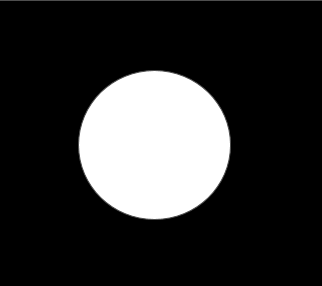

Area: 218491.48587186294
Perimeter:  493.2447278499603
Roundness 0.8980688115972061

square


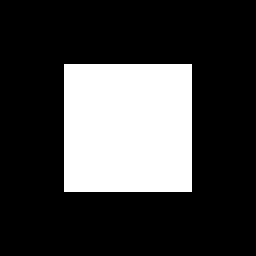

Area: 202682.99163899908
Perimeter:  508.0
Roundness 0.7853981633974483

triangle


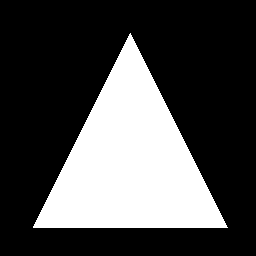

Area: 236473.9622210109
Perimeter:  662.357426404953
Roundness 0.5390120920947209



In [10]:
def compute_roundness(im):
  #이진 영상의 외곽선 찾기
  contours, hierarchy = cv2.findContours(np.array(im, dtype = np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # im에 대해 외곽선 찾기
  #영역의 계수를 계산하여 분모 계산
  a = cv2.contourArea(contours[0]) * 4 * math.pi # 외곽선 영역에 포함된 영역의 크기 a
  #영역의 둘레를 계산하여 분자 계산
  b = math.pow(cv2.arcLength(contours[0], True), 2)
  print("Area:", a)
  print("Perimeter: ", cv2.arcLength(contours[0], True)) # closed(True)된 여역의 둘레 길이 계산 b
  #원형율 계산
  if b==0:
   return 0
  return a / b

image = ['circle','square','triangle']
for i in image:
  img = '/content/gdrive/My Drive/Image_Processing/%s.bmp'%i
  gray_img = cv2.imread(img, 0)
  print(i)
  cv2_imshow(gray_img)
  #threshold이용 binary image로 변환 im
  _, im = cv2.threshold(gray_img, 128, 255, 0)

  print("Roundness", compute_roundness(im))
  print()

4. 신장율 Elongation

  신장율은 물체를 포함하는 최소의 사각형을 만들고 

  사각형 최소 경계선의 가로-세로비(aspect ratio)를 측정하는 방법

  최소사각형은 물체의 중심점, 물체의 기울기로 얻은 장축과 단축을 이용하여 그림
  


신장율 알고리즘 구현

Input image


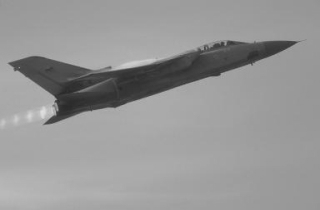

Binary image


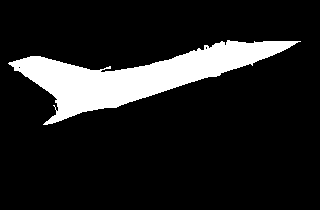

Morphology Dilation->noise removal


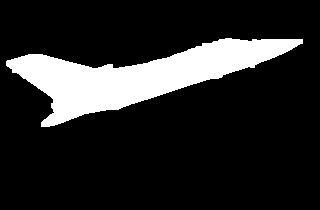

Bounding Box and Circles


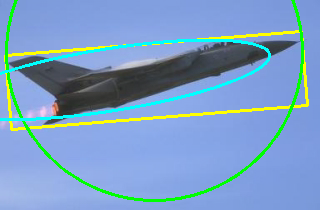

In [4]:
img_color = '/content/gdrive/My Drive/Image_Processing/airplane.bmp'
img_color = cv2.imread(img_color, 1)
gray_img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
print("Input image")
cv2_imshow(gray_img)

#threshold를 이용하여 binary image로 변환
_, img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY_INV)
print("Binary image")
cv2_imshow(img)
print("Morphology Dilation->noise removal")
kernel = np.ones((5,5), np.uint8)
mor_img = cv2.dilate(img, kernel)
cv2_imshow(mor_img)

contours, hierarchy = cv2.findContours(np.array(mor_img, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
#회전(기울어짐) 고려하지 않는 바운딩 박스
x, y, w, h = cv2.boundingRect(cnt)

#회전(기울어짐) 고려하는 바운딩 박스
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img_color, [box], 0, (0, 255, 255), 2)

#회전(기울어짐) 고려하는 타원
(x, y), radius = cv2.minEnclosingCircle(cnt)
center = (int(x), int(y))
radius = int(radius)
cv2.circle(img_color, center, radius, (0, 255, 0), 2)

#회전(기울어짐) 고려하는 타원
ellipse = cv2.fitEllipse(cnt)
cv2.ellipse(img_color, ellipse, (255, 255, 0), 2)

#신장율
E = np.fabs(w-h)/h
print("Bounding Box and Circles")
cv2_imshow(img_color)
print("Elongation : ", E)

# 불변 모멘트 기법 Invariant moment

영상에서 모멘트는 영상 픽셀 강도의 가중치 평균을 나타냄

영역 분할 후에 물체를 표현하는데 활용되고 객체움직임에도 변하지 않는 특징을 제공함



불변 모멘트 값 계산 프로그램 구현

In [5]:
from math import copysign, log10

Elongation :  2.337078651685393


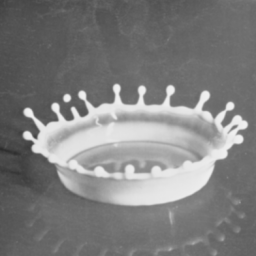

Segmented image


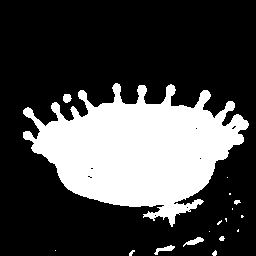

Moment
Phi 1 :3.10033, Phi 2 :6.89421, Phi 3 :10.26521, Phi 4 :12.60768, Phi 5 :-24.35316, Phi 6 :-16.48663, Phi 7 :-24.10400, 


In [6]:
# 모멘트 값을 로그를 취해서 변형된 값으로 출력할지 여부
showLogTransformedHuMoments = True

img = cv2.imread('/content/gdrive/My Drive/Image_Processing/milkdrop.bmp')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)# color -> gray
cv2_imshow(gray_img)

#threshold를 이용하여 binary image로 변환
_,im = cv2.threshold(gray_img,128,255,0) # 임계값128 넘으면 255적용

print("Segmented image")  
cv2_imshow(im)
#cv2.moment 함수를 사용하여 모멘트 계산. 사전형 자료에 담아 리턴
moment = cv2.moments(im)
# cv2.HuMoments함수를 이용하여 Hu 모멘트 계산
huMoments = cv2.HuMoments(moment)

print("Moment")  
# 7개의 불변 모멘트. 정규화 모멘트로부터 정의된 불변 모멘트들
for i in range(0,7):
  if showLogTransformedHuMoments:
    print("Phi",i+1,":{:.5f}".format(-1*copysign(1.0,huMoments[i])*log10(abs(huMoments[i]))),end=', ')
  else:
    print("Phi",i+1,huMoments[i],end=' ')
print()